In [1]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [5]:
# NOTE: You will need to set AWS access keys for the MCP environment
# !env

In [2]:
%%time
client = boto3.client('logs', region_name='us-west-2')

query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like "Searching for collections"
| filter @message like "concept_id"
| parse @message /concept_id "(?<concept_id>\S+)"/
| stats count(*) as number_queries by concept_id
| sort by number_queries desc
"""

log_group = 'cmr-search-ops'
datetime_str = '05/18/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(60)
    logs_response = client.get_query_results(
        queryId=query_id
    )

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
CPU times: user 192 ms, sys: 39 ms, total: 231 ms
Wall time: 8min 2s


In [3]:
# Save the results so we don't have to re-run the query
filename = f"concept_id_search-{query_id}.json"
with open(filename, "w+") as f:
    f.write(json.dumps(logs_response))
    f.close()    

In [4]:
data = json.loads(open(filename).read())

In [5]:
restructured_data = []
limit = 25
for result in data['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data[0:limit]

[{'number_queries': '986'},
 {'concept_id': 'C1202028193-NASA_MAAP', 'number_queries': '20'},
 {'concept_id': 'C1201460047-NASA_MAAP', 'number_queries': '16'},
 {'concept_id': 'C1200115768-NASA_MAAP', 'number_queries': '14'},
 {'concept_id': 'C1200110748-NASA_MAAP', 'number_queries': '13'},
 {'concept_id': 'C1201746153-NASA_MAAP', 'number_queries': '11'},
 {'concept_id': 'C1201746156-NASA_MAAP', 'number_queries': '10'},
 {'concept_id': 'C1200110769-NASA_MAAP', 'number_queries': '10'},
 {'concept_id': 'C1200110729-NASA_MAAP', 'number_queries': '10'},
 {'concept_id': 'C1200116827-NASA_MAAP', 'number_queries': '8'},
 {'concept_id': 'C1200000522-NASA_MAAP', 'number_queries': '8'},
 {'concept_id': 'C1201702030-NASA_MAAP', 'number_queries': '8'},
 {'concept_id': 'C1201300747-NASA_MAAP', 'number_queries': '7'},
 {'concept_id': 'C1202077988-NASA_MAAP', 'number_queries': '6'},
 {'concept_id': 'C1200115748-ESA_MAAP', 'number_queries': '5'},
 {'concept_id': 'C1201309827-NASA_MAAP', 'number_querie

In [6]:
cmr_url = 'https://cmr.maap-project.org'
collections_search_url = f"{cmr_url}/search/collections.json"
granules_search_url = f"{cmr_url}/search/granules.json"
results_dict = {}
for entry in restructured_data[0:limit]:
    # There's 1 blank concept_id entry
    if 'concept_id' in entry:
        concept_id = entry['concept_id']
        if concept_id.startswith('C'):
            cmr_response = requests.get(f"{collections_search_url}?concept_id={concept_id}")
        else:
            # Are we interested in granules searches? very limited results besides
            next
            #cmr_response = requests.get(f"{granules_search_url}?concept_id={concept_id}")
        number_queries = entry['number_queries']
        cmr_data = json.loads(cmr_response.text)['feed']['entry']
        if len(cmr_data) > 0:
            short_name = json.loads(cmr_response.text)['feed']['entry'][0]['short_name']
            results_dict[short_name] = int(number_queries)
        else:
            print(f"No entries found for {entry['concept_id']}")
    

No entries found for C2237824918-ORNL_CLOUD


In [10]:
results_dict = {k: v for k, v in sorted(results_dict.items(), key=lambda item: item[1], reverse=True)}
results_dict

{'GEDI_L4A_AGB_Density_V2_1_2056': 20,
 'GEDI02_B': 16,
 'AfriSAR_AGB_Maps_1681': 14,
 'ABLVIS1B': 13,
 'Landsat8_SurfaceReflectance': 10,
 'AFLVIS2': 10,
 'GEDI_CalVal_Field_Data': 8,
 'SRTMGL1': 8,
 'GEDI_L3_LandSurface_Metrics_V2_1952': 8,
 'test_collection_feb23': 6,
 'L2_USER_DATA': 5,
 'GEDI_L4B_Gridded_Biomass_2017': 4,
 'ATL08': 3,
 'ATL03': 3,
 'AFRISAR_DLR': 3,
 'GEDI02_A': 2,
 'Global_PALSAR2_PALSAR_Mosiac': 2,
 'GEDI_L4A_AGB_Density_V2_1986': 2}

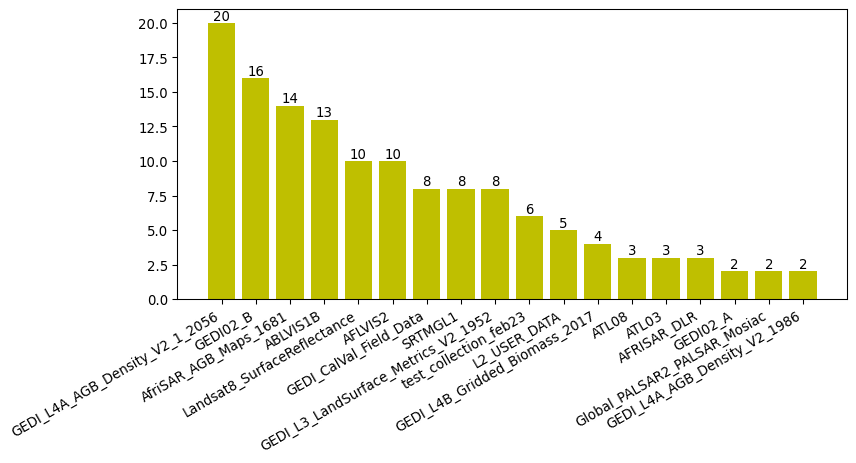

In [11]:
# data set
collections = list(results_dict.keys())
number_queries = list(results_dict.values())

plt.figure(figsize=(9, 4), dpi=96)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', va= 'bottom')

plt.bar(collections, number_queries, color='y')
addlabels(collections, number_queries)
plt.xticks(rotation=30, ha='right')
plt.show()